## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [19]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


Transforming y by taking the log and subtracting mean of 8.40834258588723 

The kernel is 0.658**2 * RBF(length_scale=[0.0326, 0.0395]) + WhiteKernel(noise_level=0.568) with a log marginal likelihood value of -1365.323931477832


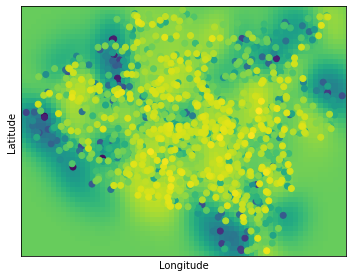

Proportion of anomalous points is 0.042152466367713005


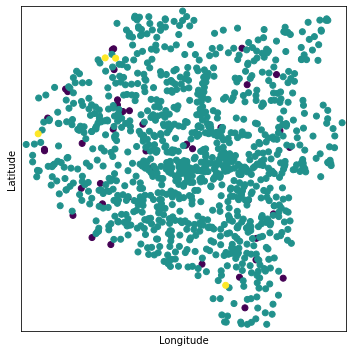

In [2]:
# Solution follows:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# longitude and latitude of each sensor
X = Data1.iloc[:,0:2].values

# average daily traffic count of each sensor
y = np.log(Data1.iloc[:,2].values)
themean = y.mean()
y -= themean
print("Transforming y by taking the log and subtracting mean of", themean, "\n")


kernel = 1 * RBF(length_scale=(0.01, 0.01)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10,random_state=1)

gp.fit(X, y)

print("The kernel is", gp.kernel_, "with a log marginal likelihood value of", gp.log_marginal_likelihood_value_)

# predictions for the given points 
y_pred, sigma = gp.predict(X, return_std=True)

# predictions on a mesh
x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])

# first figure shows the true y points and our predictions on the mesh
plt.figure(figsize=(5, 5))
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower", vmin=y.min(), vmax=y.max())
plt.scatter(X[:, 0], X[:, 1], c=y, vmin=y.min(), vmax=y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.show()

# second figure shows standardized residuals at each point
z2=(y-y_pred)/sigma
print("Proportion of anomalous points is", (abs(z2)>2).sum()/(0.0+len(z2)))

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=(1.0*(z2>2)-1.0*(z2<-2)), vmin=-1, vmax=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 2 points, center (10, 10), standard deviation 1

B: 200 points, center (15, 20), standard deviation 1

C: 150 points, center (35, 5), standard deviation 5

D: 100 points, center (0, 0), standard deviation 0.1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(10, 11)	Anomaly / Not Anomaly

(15, 19)	Anomaly / Not Anomaly

(35, 2)		Anomaly / Not Anomaly

(1, 0)		Anomaly / Not Anomaly

### Solution to Question 2:

(1,0) is mapped to Cluster A but is 10 standard deviations away, so it is an anomaly.

(35,2) is mapped to cluster B and is 0.6 standard deviations away, so it is not an anomaly.

(15,19) is mapped to cluster C and is 1 standard deviation away, so it is not an anomaly.

(10,11) is mapped to cluster D which is a tiny cluster (only 2 points), so it is an anomaly.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [36]:
Data2=pd.read_csv("2022CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','\% Low birth weight births','\% Smokers','\% Obese','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",20,10.0,20,35,32,63.0,16,32.0,578.1,...,15.0,5.1,28.0,12.9,272.0,69.0,9.5,15,87.0,41
1,"Baldwin, Alabama",17,8.0,20,30,28,75.0,22,32.0,336.0,...,12.0,4.4,18.0,10.1,204.0,75.0,7.2,12,83.0,38
2,"Barbour, Alabama",31,12.0,28,40,42,50.0,14,38.0,895.2,...,38.0,6.0,54.0,7.3,414.0,82.0,9.0,15,84.0,37
3,"Bibb, Alabama",25,10.0,25,41,38,11.0,16,21.0,540.3,...,22.0,5.4,37.0,8.9,89.0,103.0,9.4,11,88.0,55
4,"Blount, Alabama",23,8.0,22,39,33,23.0,16,15.0,404.7,...,19.0,4.8,23.0,7.4,483.0,105.0,9.4,10,88.0,60


In [37]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator

# preprocessing
x=Data2.iloc[:,1:]
x=x.apply(pd.to_numeric, args=('coerce',))
x=pd.concat((Data2.County,x),axis=1)
x=x.dropna()
x.index=range(len(x))

# convert to categorical
xx=[]
for i in range(26):
    a=pd.cut(np.asarray(x)[:,i+1],5,labels=[0,1,2,3,4])
    xx.append(a)
x3=np.asarray(xx).T
x4=pd.DataFrame(x3)
x4.columns=list(Data2.columns)[1:]

# select only the 5 attributes
x5=x4.loc[:,["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'",
             "'Average Daily PM2.5'"]]
x5.columns=["smokers","obese","crimerate","incomeratio","childrenInPoverty","dailyPM2_5"]

# structure learning
hc = HillClimbSearch(x5)
best_model = hc.estimate(scoring_method=BicScore(x5))
print(best_model.edges())

# parameter learning
model = BayesianModel(best_model.edges())
model.fit(x5, estimator=MaximumLikelihoodEstimator)

# log-likelihood computation
x["LL"] = 0.0
for i in x5.index:
    x.loc[i,"LL"] = LL(x5.loc[i,:],model) 
        
print(x.sort_values(by="LL").head())
del x["LL"]

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('smokers', 'obese'), ('obese', 'dailyPM2_5'), ('incomeratio', 'childrenInPoverty'), ('childrenInPoverty', 'smokers'), ('childrenInPoverty', 'crimerate')]


C:\Users\ca2735\anaconda3\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


                                          County  \
1580                          New York, New York   
1082                      Suffolk, Massachusetts   
2255                              Hidalgo, Texas   
269   District of Columbia, District of Columbia   
173                      Los Angeles, California   

      '\% Reporting Fair/Poor Health'  '\% Low birth weight births'  \
1580                               17                           8.0   
1082                               19                           8.0   
2255                               34                           9.0   
269                                15                          10.0   
173                                22                           7.0   

      '\% Smokers'  '\% Obese'  '\% Physically Inactive'  \
1580            11          22                        22   
1082            13          25                        29   
2255            16          48                        37   
269             14  

In [38]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

data3_1=x3
data3=x
data3.index=range(len(data3))
KM = KMeans(n_clusters=3, random_state=999)
KM.fit(data3_1)

res_km = pd.DataFrame(KM.transform(data3_1)).apply(lambda x: min(x), axis=1)
res_km.name = 'distance'
print("============KMeans=====================")
print(pd.concat([data3['County'], res_km], axis=1).sort_values('distance', ascending=False)[:5])

GM = GaussianMixture(n_components=3, random_state=999)
GM.fit(data3_1)

res_gm = pd.DataFrame(GM.score_samples(data3_1))
res_gm.columns = ['logLikelihood']
print("===========Gaussian=====================")
print(pd.concat([data3['County'], res_gm], axis=1).sort_values('logLikelihood')[:5])

============KMeans=====================
                       County  distance
2318          Presidio, Texas  7.325273
985   East Carroll, Louisiana  7.117216
1573          Kings, New York  6.921409
1580       New York, New York  6.829453
1553          Bronx, New York  6.631560
===========Gaussian=====================
                                          County  logLikelihood
269   District of Columbia, District of Columbia     -76.998007
2318                             Presidio, Texas     -70.616237
1553                             Bronx, New York     -66.743072
1766                                Holmes, Ohio     -58.629625
1580                          New York, New York     -56.702670
